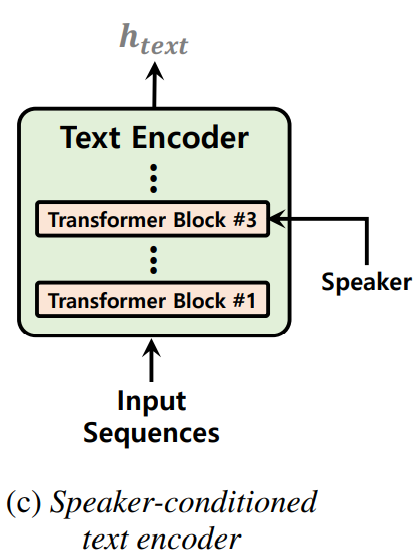

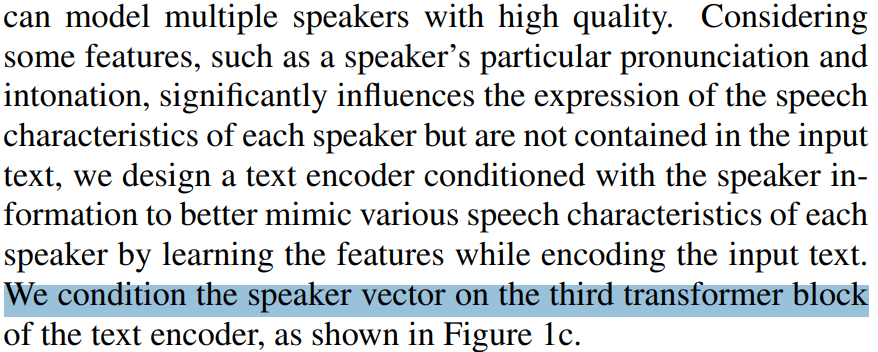

In [ ]:
# there are several ways to add speaker info to the transformer layer


In [1]:
import os
os.chdir(r'../../vits2_pytorch')

In [5]:
import torch
from torch import nn
from torch.nn import functional as F

from modules import *
from attentions import *

In [6]:
class Encoder(nn.Module): #backward compatible vits2 encoder
  def __init__(
      self, hidden_channels, filter_channels, n_heads, n_layers, kernel_size=1, p_dropout=0., window_size=4, **kwargs
      ):
    super().__init__()
    self.hidden_channels = hidden_channels
    self.filter_channels = filter_channels
    self.n_heads = n_heads
    self.n_layers = n_layers
    self.kernel_size = kernel_size
    self.p_dropout = p_dropout
    self.window_size = window_size

    self.drop = nn.Dropout(p_dropout)
    self.attn_layers = nn.ModuleList()
    self.norm_layers_1 = nn.ModuleList()
    self.ffn_layers = nn.ModuleList()
    self.norm_layers_2 = nn.ModuleList()
    # if kwargs has spk_emb_dim, then add a linear layer to project spk_emb_dim to hidden_channels
    if 'gin_channels' in kwargs:
      self.gin_channels = kwargs['gin_channels']
      if self.gin_channels != 0:
        self.spk_emb_linear = nn.Linear(self.gin_channels, self.hidden_channels)
        # vits2 says 3rd block, so idx is 2 by default
        self.cond_layer_idx = kwargs['cond_layer_idx'] if 'cond_layer_idx' in kwargs else 2
        print(self.gin_channels, self.cond_layer_idx)
        assert self.cond_layer_idx < self.n_layers, 'cond_layer_idx should be less than n_layers'
      
    for i in range(self.n_layers):
      self.attn_layers.append(MultiHeadAttention(hidden_channels, hidden_channels, n_heads, p_dropout=p_dropout, window_size=window_size))
      self.norm_layers_1.append(LayerNorm(hidden_channels))
      self.ffn_layers.append(FFN(hidden_channels, hidden_channels, filter_channels, kernel_size, p_dropout=p_dropout))
      self.norm_layers_2.append(LayerNorm(hidden_channels))

  def forward(self, x, x_mask, g=None):
    attn_mask = x_mask.unsqueeze(2) * x_mask.unsqueeze(-1)
    x = x * x_mask
    for i in range(self.n_layers):
      if i == self.cond_layer_idx and g is not None:
        g = self.spk_emb_linear(g.transpose(1, 2))
        g = g.transpose(1, 2)
        x = x + g
      y = self.attn_layers[i](x, x, attn_mask)
      y = self.drop(y)
      x = self.norm_layers_1[i](x + y)

      y = self.ffn_layers[i](x, x_mask)
      y = self.drop(y)
      x = self.norm_layers_2[i](x + y)
    x = x * x_mask
    return x

In [7]:
# hidden_channels, filter_channels, n_heads, n_layers, kernel_size=1, p_dropout=0., window_size=4, **kwargs
txtEncoder = Encoder(
    hidden_channels=192,
    filter_channels=768,
    n_heads=2,
    n_layers=6,
    gin_channels=256,
)

256 2


In [8]:
# test with random data
x = torch.randn(1, 192, 5)
x_mask = torch.ones(1, 1, 5)
g = torch.randn(1, 256, 1)
hidden_x = txtEncoder(x, x_mask, g)